In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.Markovian_4DLorenz.recursive_Markovian_PostMeanScore_4DLorenz_T256_H05_tl_110data_StbleTgt import get_config

In [2]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

def plot_ewma_losses(epochs, losses):
    start_idx = 00
    def compute_ema(loss_tensor, beta):
        ema_values = np.zeros_like(loss_tensor)  # Initialize EMA tensor
        ema_values[0] = loss_tensor[0]  # First value stays the same

        for i in range(1, len(loss_tensor)):
            ema_values[i] = beta * ema_values[i - 1] + (1 - beta) * loss_tensor[i]

        return ema_values
    # Define EMA decay rates
    beta_short = 0.9   # Short-term trend (reacts quickly)
    beta_long = 0.99   # Long-term trend (smoother)

    # Compute EMAs
    short_term_ema = compute_ema(losses, beta_short)
    long_term_ema = compute_ema(losses, beta_long)
    plt.scatter(epochs[start_idx:], (short_term_ema[start_idx:]),s=2, label="Short Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()
    plt.scatter(epochs[start_idx:], (long_term_ema[start_idx:]),s=2, label="Long Term Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [3]:
config = get_config()
deltaT = config.deltaT
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
print(config.loss_factor)

2


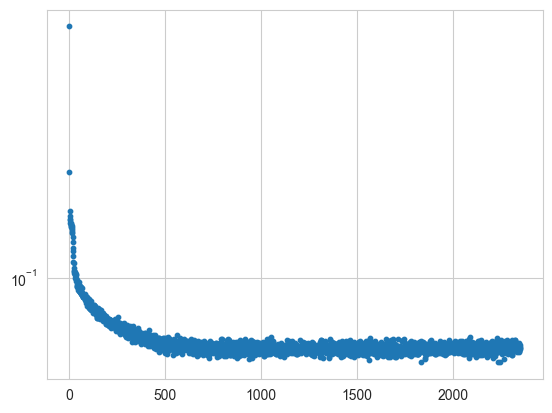

2349

In [4]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.scatter(Nepochs_losses,  losses, s=10)
plt.yscale("log")
plt.show()
plt.close()
Nepochs_losses[-1]

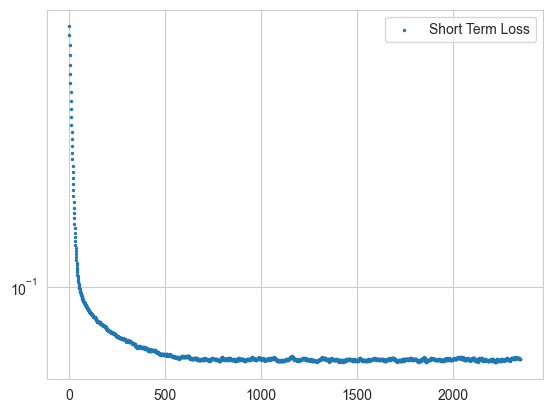

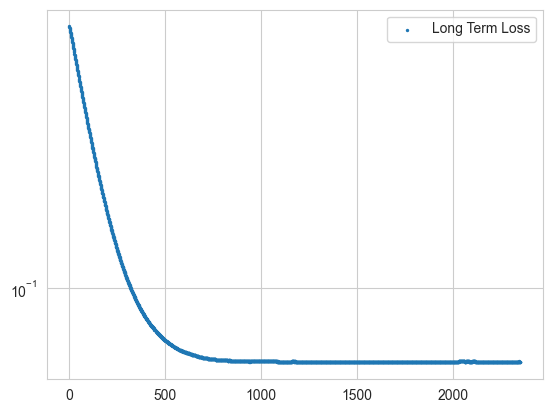

In [5]:
plot_ewma_losses(epochs=Nepochs_losses, losses=losses)

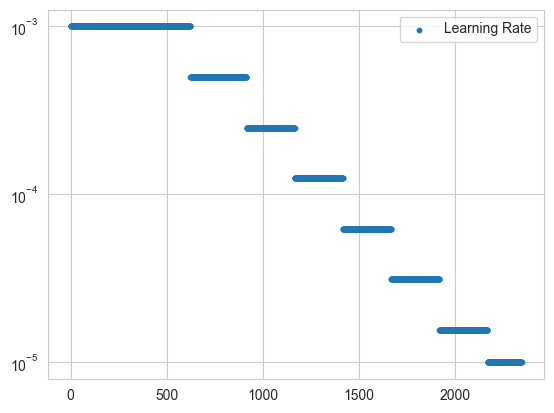

1e-05


In [6]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss_LR", 'rb') as f:
        LRs = (np.array(pickle.load(f)).astype(float))
start = 0#935
end = -1#935+152
plt.scatter(Nepochs_losses[start:end],  LRs[start:end], s=10, label="Learning Rate")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()
print(LRs[-1])

In [7]:
def get_drift_files(config):
    ts_type = f"ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_".replace(".", "")
    include =  (f"_{1}NDT_{config.loss_factor}LFac_BetaMax{config.beta_max:.1e}_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_score_dir = root_dir + f"ExperimentsResults/TSPM_Markovian/4DLnz/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_score_dir):
        if "_MLP_" in file and ts_type in file and include in file:
            if "DriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_score_dir+file)
            elif "DriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_score_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files, driftoostrack_local_files, Nepochs_track

In [8]:
drift_true_files, drift_local_files, Nepochs_track = get_drift_files(config)
len(Nepochs_track)

705

In [9]:
drift_track_rmses = {}
epochs_iter = Nepochs_track
Nepochs_keep = []
for Nepoch, true, local in zip(*[epochs_iter, drift_true_files, drift_local_files]):
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
        Nepochs_keep.append(Nepoch)
    except (FileNotFoundError, ValueError) as e:
        print(e)
        del all_true_states, all_local_states, all_local_errors, total_local_errors
        continue
Nepochs_track = Nepochs_keep
drift_track_rmses

{4: 0.005849409200623295,
 8: 0.0035554396356088265,
 10: 0.0034199566904973095,
 14: 0.003447750362303749,
 18: 0.0033547599627636857,
 20: 0.003856903077185941,
 24: 0.0029950462334807455,
 28: 0.0031262582553014547,
 30: 0.0031489919582071645,
 34: 0.0034311950340118183,
 38: 0.003958261007354341,
 40: 0.0029330455218375814,
 44: 0.0032314371379349957,
 48: 0.0028127988730879063,
 50: 0.0032824484266457954,
 54: 0.002987459846996435,
 58: 0.003111270725645626,
 60: 0.002997515463942012,
 64: 0.0031395305322989694,
 68: 0.002879167755866155,
 70: 0.0030652299562926545,
 74: 0.0031248205495858325,
 78: 0.0030565099241608054,
 80: 0.0031184765583066763,
 84: 0.0027911136160667623,
 88: 0.0029765990617375703,
 90: 0.0030201660593519287,
 94: 0.00297642478920851,
 98: 0.0029752920141391317,
 100: 0.003067540406187916,
 104: 0.0029333828505084545,
 108: 0.002976558847895809,
 110: 0.003199614133804006,
 114: 0.0029676331719716556,
 118: 0.0029644805093413246,
 120: 0.0029885430186211955,


In [17]:
np.mean(list(drift_track_rmses.values())[-300:])

0.0019497640038191185

In [11]:
toSave = False
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.array(pickle.load(f)).astype(float)
Nepochs_losses = np.arange(losses.shape[0])

In [12]:
common_epochs = np.intersect1d(Nepochs_losses, Nepochs_track)
common_epochs = np.intersect1d(common_epochs, np.arange(10, 3500))
start_idx = 0
common_epochs = common_epochs[start_idx:]
losses_idx = [np.argwhere(c == Nepochs_losses)[0,0] for c in common_epochs]
track_idx = [np.argwhere(c == Nepochs_track)[0,0] for c in common_epochs]
red_losses = losses[losses_idx]
track_rmses = np.array(list(drift_track_rmses.values()))[track_idx]
common_epochs

array([  10,   14,   18,   20,   24,   28,   30,   34,   38,   40,   44,
         48,   50,   54,   58,   60,   64,   68,   70,   74,   78,   80,
         84,   88,   90,   94,   98,  100,  104,  108,  110,  114,  118,
        120,  124,  128,  130,  134,  138,  140,  144,  148,  150,  154,
        158,  160,  164,  168,  170,  174,  178,  180,  184,  188,  190,
        194,  198,  200,  204,  208,  210,  214,  218,  220,  224,  228,
        230,  234,  238,  240,  244,  248,  250,  254,  258,  260,  264,
        268,  270,  274,  278,  280,  284,  288,  290,  294,  298,  300,
        304,  308,  310,  314,  318,  320,  324,  328,  330,  334,  338,
        340,  344,  348,  350,  354,  358,  360,  364,  368,  370,  374,
        378,  380,  384,  388,  390,  394,  398,  400,  404,  408,  410,
        414,  418,  420,  424,  428,  430,  434,  438,  440,  444,  448,
        450,  454,  458,  460,  464,  468,  470,  474,  478,  480,  484,
        488,  490,  494,  498,  500,  504,  508,  5

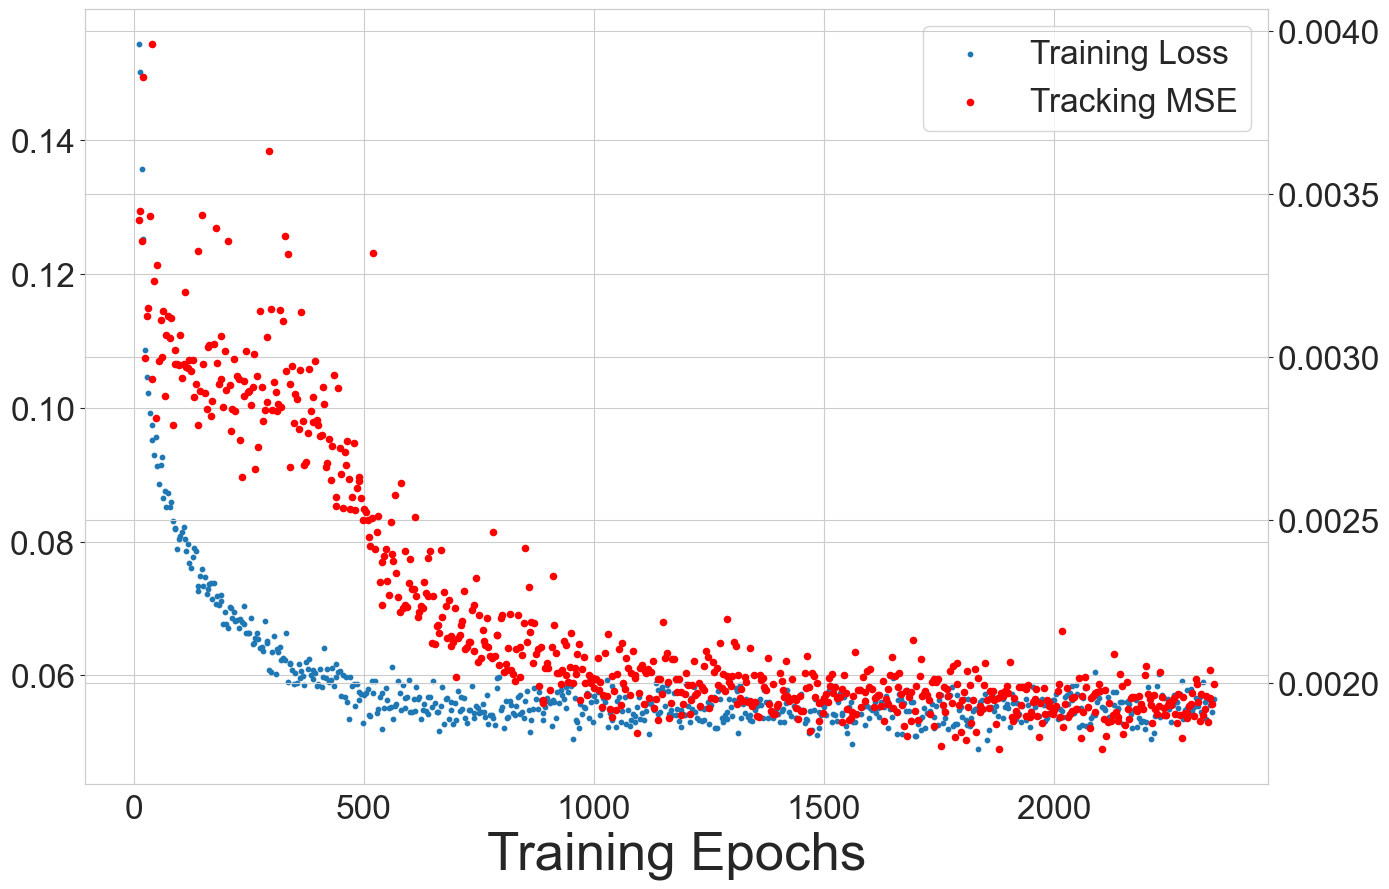

In [18]:
toSave = True
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(common_epochs, red_losses, s=10, label="Training Loss")
ax2 = ax.twinx()
sc2 = ax2.scatter(common_epochs, track_rmses, s=20, color="red",label="Tracking MSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for $\mu_{5}$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
#ax2.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, fontsize=24)
if toSave:
    if "_ST_" in config.scoreNet_trained_path:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_{config.forcing_const}FConst_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
    else:
        plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_{config.forcing_const}FConst_LossesTrack_{config.loss_factor}LFac").replace(".","")+".png",  bbox_inches='tight')
plt.show()
plt.close()

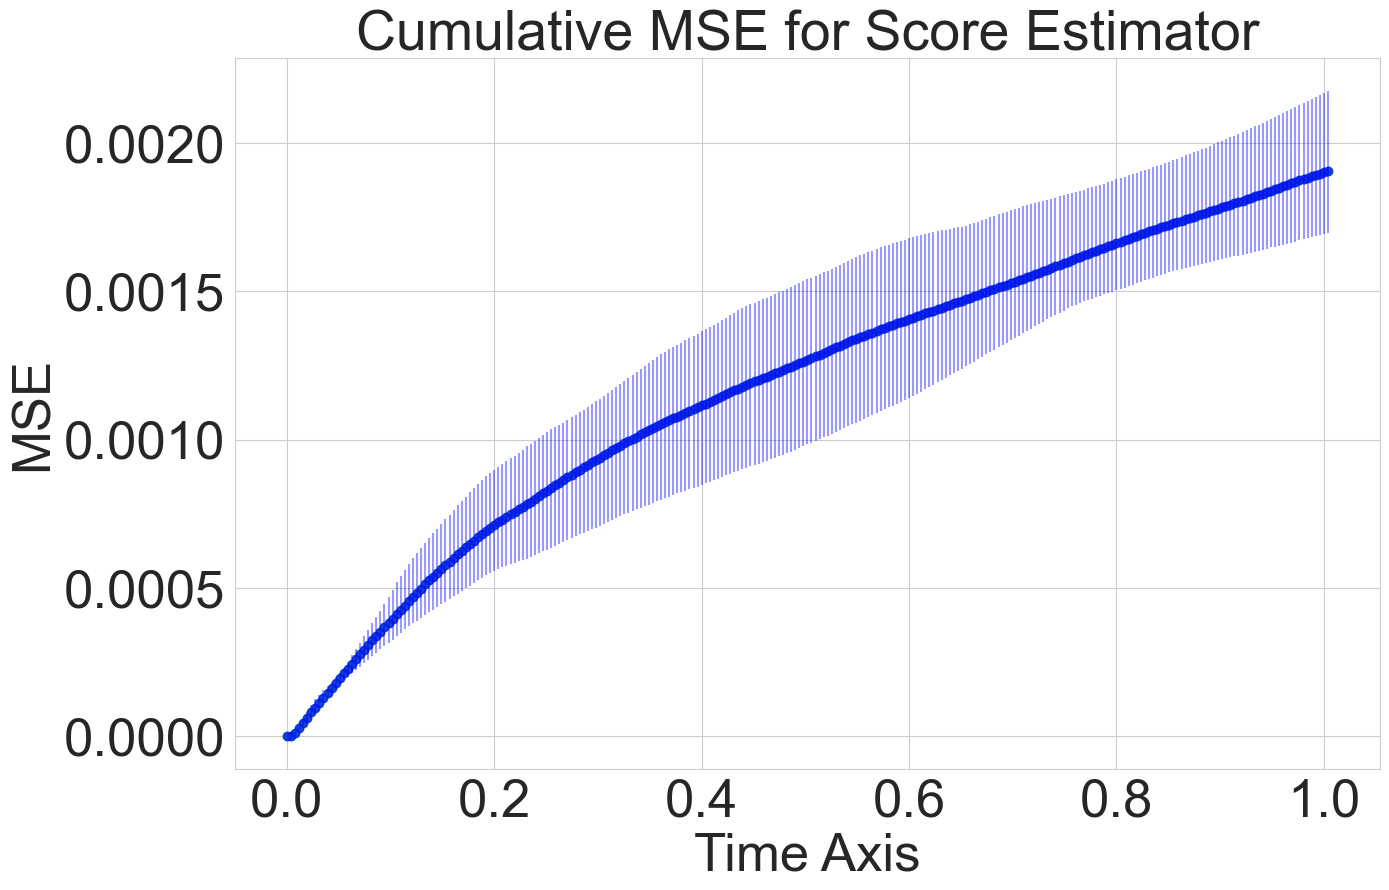

Final time cumulative MSE local-time error 0.0019066318158380848 with final IQR (0.001697407935264619, 0.0021767292702032405) at Nepoch 2000 for 0.75FConst



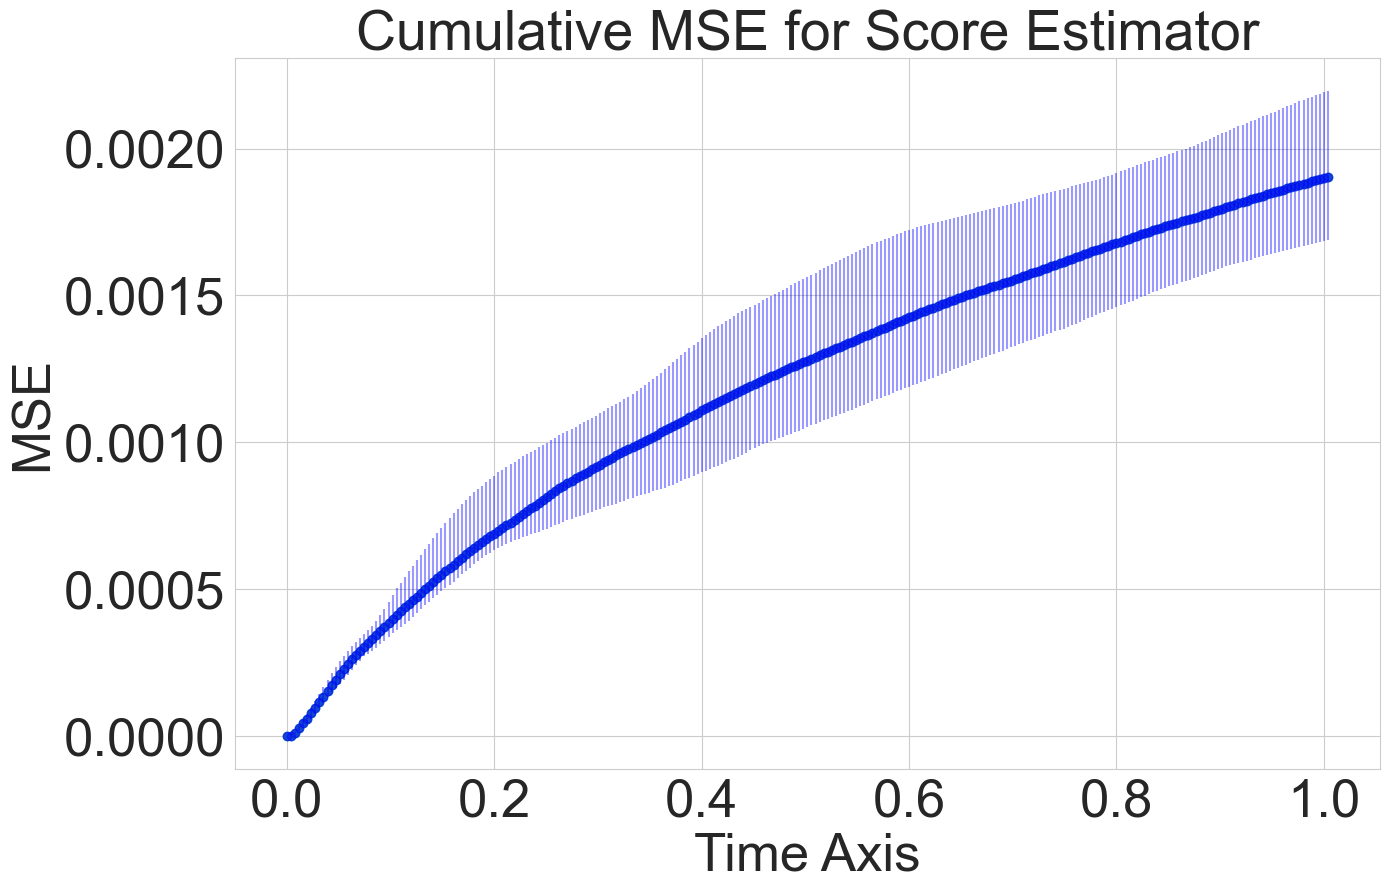

Final time cumulative MSE local-time error 0.001903418726061525 with final IQR (0.0016881520548000884, 0.002196886934494167) at Nepoch 2004 for 0.75FConst



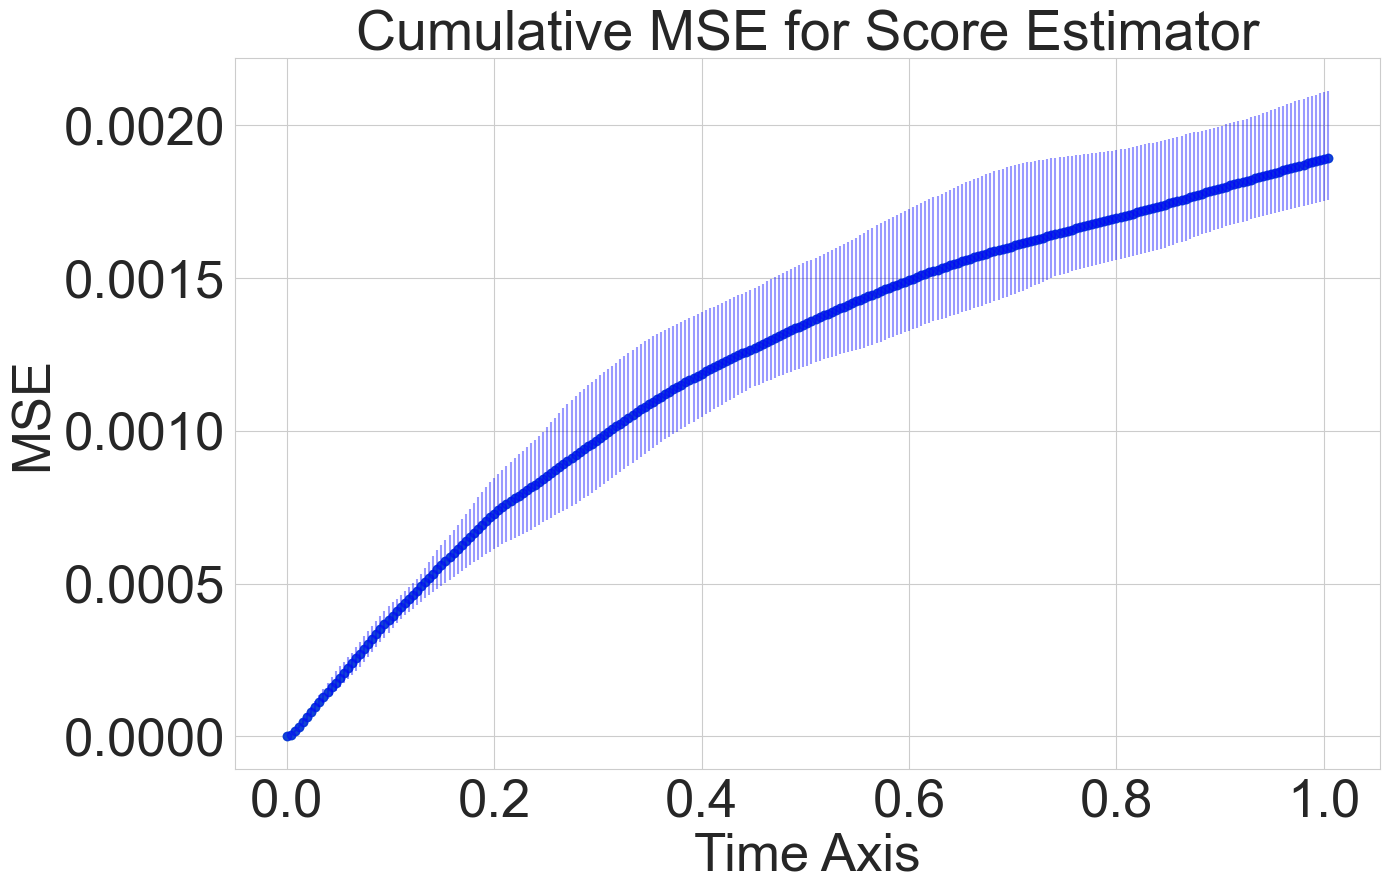

Final time cumulative MSE local-time error 0.0018934220098666345 with final IQR (0.0017563075033657008, 0.002113459868293767) at Nepoch 2020 for 0.75FConst



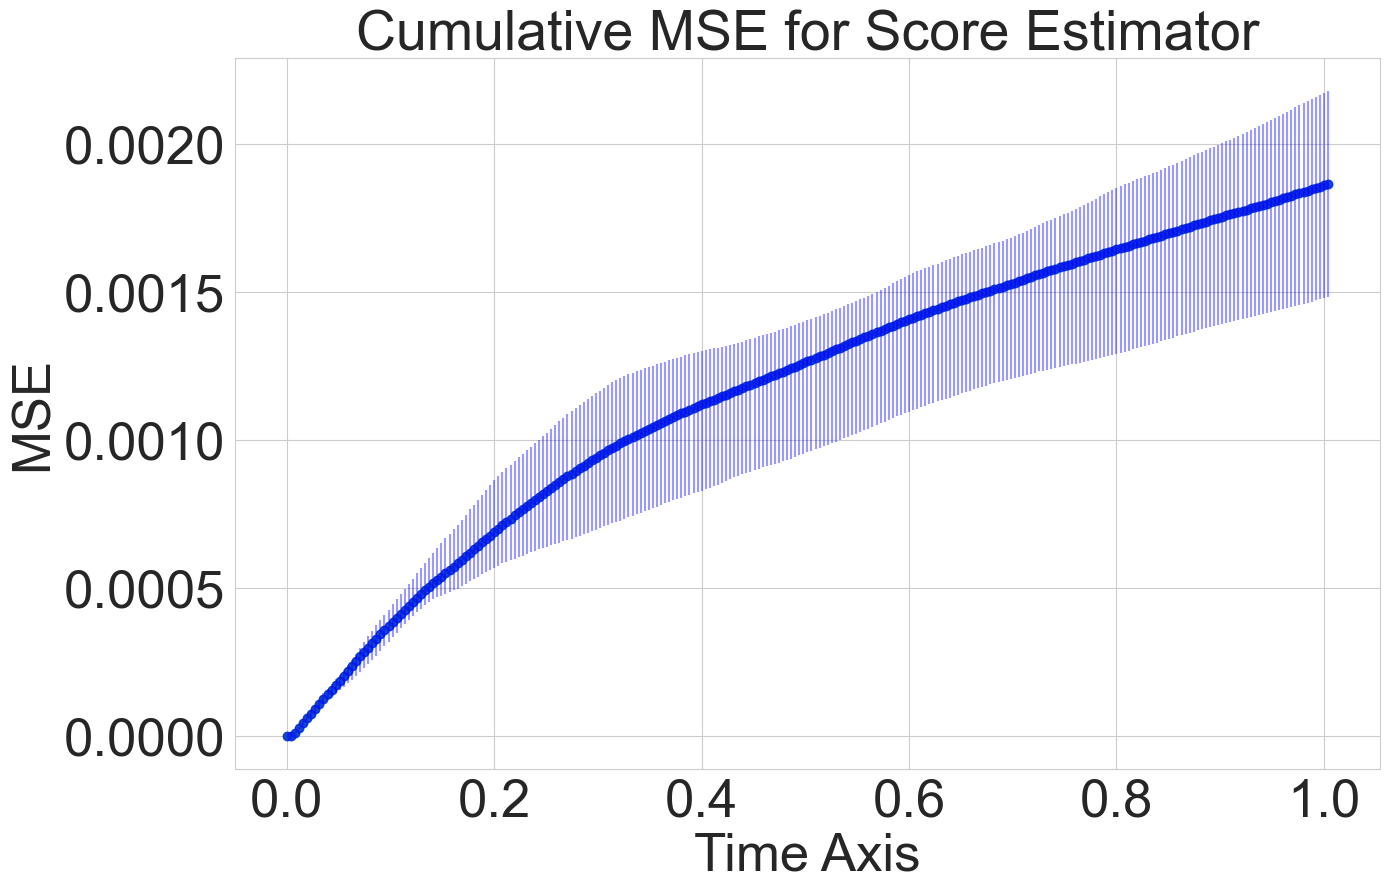

Final time cumulative MSE local-time error 0.0018651631532039207 with final IQR (0.0014853185975067962, 0.00218060416751984) at Nepoch 2028 for 0.75FConst



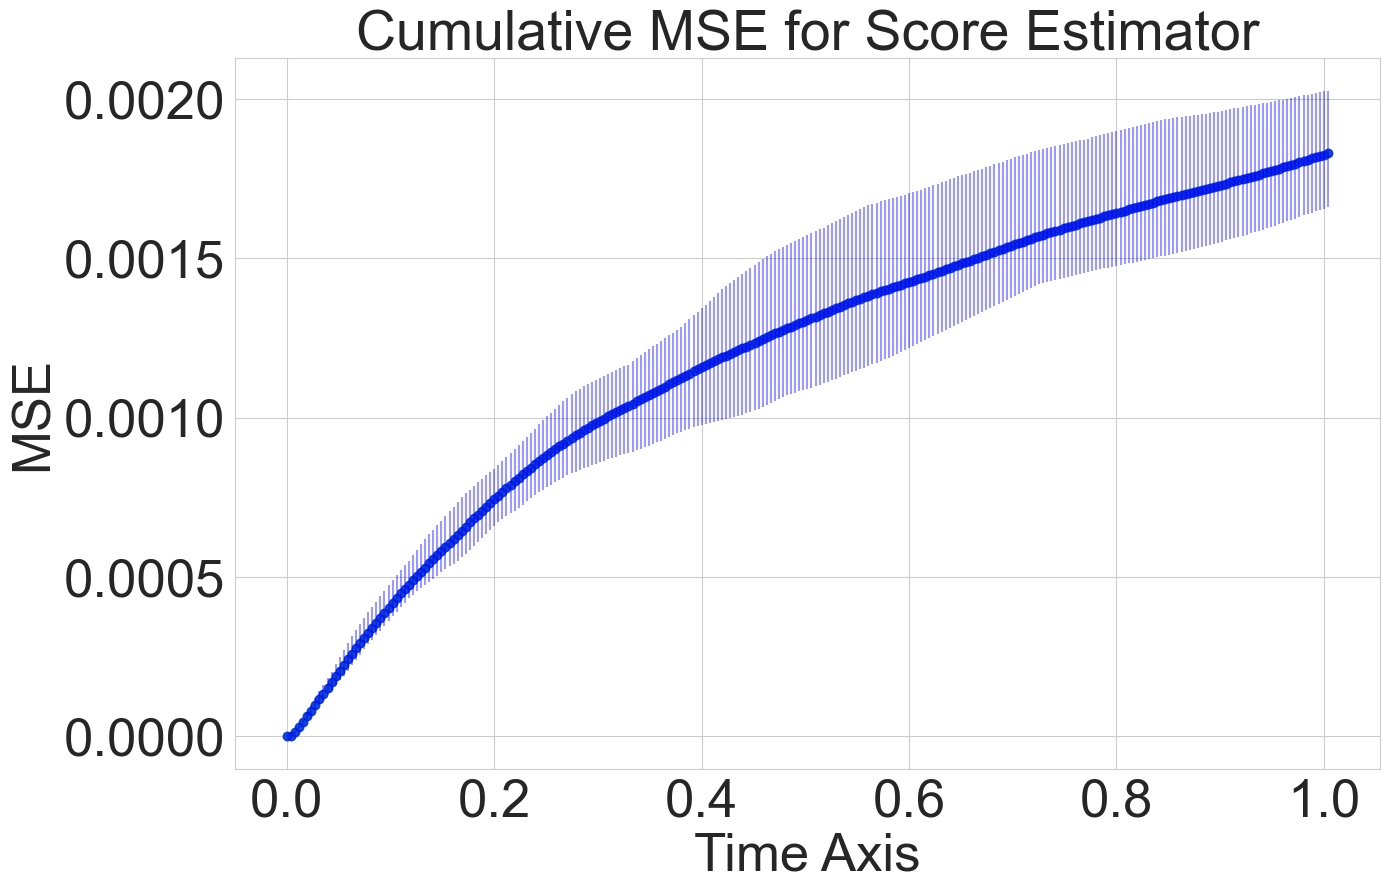

Final time cumulative MSE local-time error 0.0018293879359131521 with final IQR (0.0016603354214889355, 0.002026616325208668) at Nepoch 2064 for 0.75FConst



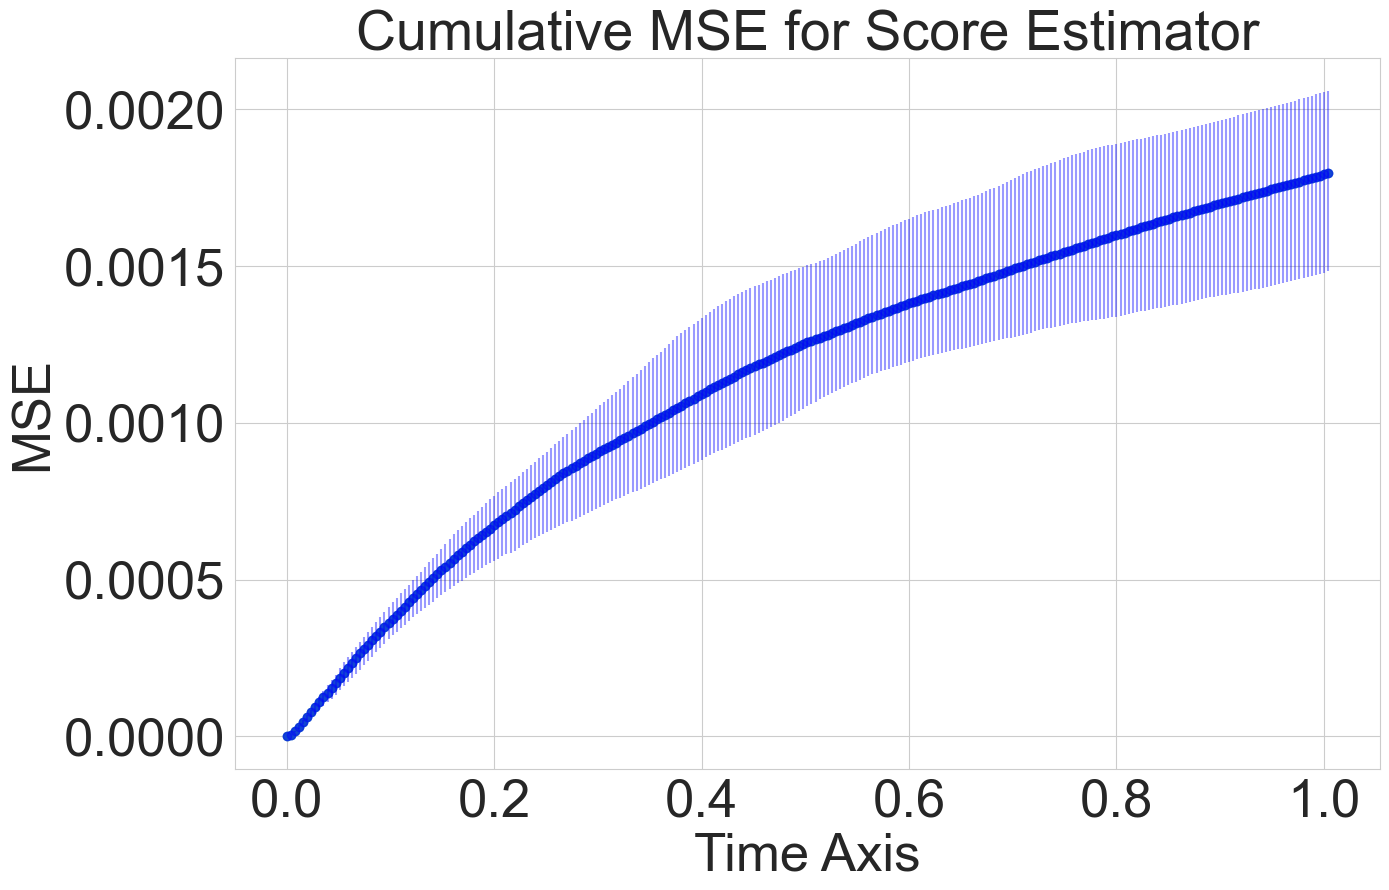

Final time cumulative MSE local-time error 0.00179676540572129 with final IQR (0.0014831446286235515, 0.002059922476889282) at Nepoch 2110 for 0.75FConst



In [19]:
curr_rmse = np.inf
toSave = True
for f_idx in range(len(common_epochs)):
    Nepoch = common_epochs[f_idx]
    true = drift_true_files[f_idx]
    local = drift_local_files[f_idx]
    try:
        if Nepoch < 2000: raise FileNotFoundError
        num_diff_times = 1
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(all_local_errors, axis=0)
        total_local_errors_minq = np.quantile(all_local_errors, axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(all_local_errors, axis=0,q=0.975)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative MSE for Score Estimator",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/TSPM_MLP_PM_ST_{config.feat_thresh:.3f}FTh_{config.ndims}DLnz_DriftTrack_{Nepoch}Nep_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue